In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
%matplotlib inline

In [326]:
toy_data = [[1, "1:3:12", -23.613, -46.0443],
            [1, "1:3:13", -23.613, -46.6443],
            [1, "1:3:50", -23.713, -46.6443],
            [1, "1:4:12", -23.814, -46.6443],
            [1, "1:4:13", -23.613, -46.0443],
            [1, "1:4:50", -23.713, -46.0443],
            [2, "1:3:12", -23.313, -46.9443],
            [2, "1:3:13", -23.513, -46.9443],
            [2, "1:3:50", -23.713, -46.9443],
            [2, "1:4:12", -23.314, -46.9443],
            [2, "1:4:13", -23.513, -46.9443],
            [2, "1:4:50", -23.713, -46.9443]]

columns = ["id", "time", "lat", "lon"]
columns_orig = ["id_orig", "time_orig", "lat_orig", "long_orig"]

In [363]:
john = pd.read_csv("./HackEMTU/dados_jaozinho")
john.columns = columns
john

,id,time,lat,lon
0,440224,2017-10-07 14:31:45,-23.399715,-46.523525
1,440224,2017-10-03 16:09:11,-23.399715,-46.616001
2,440224,2017-10-06 12:15:18,-23.464047,-46.583242
3,440224,2017-10-05 14:23:16,-23.464047,-46.535917
4,440224,2017-10-01 22:04:33,-23.464047,-46.565727
5,440224,2017-10-02 22:19:52,-23.464047,-46.508462


In [391]:
merged = pd.read_csv("./HackEMTU/merged.csv")
print(merged.shape)
merged.columns = ["nothing"] + columns
print(merged.head(5))
merged_new = pd.concat([merged.id, merged.lon, merged.time, merged.lat], axis=1)
merged_new.columns = columns
merged_new.head(5)


(443, 5)
   nothing       id       time        lat                  lon
0        1   425787 -23.551603 -46.927933  2017-10-07 07:43:14
1        2    97467 -23.551586 -46.927928  2017-10-07 07:59:13
2        3  1011020 -23.551586 -46.927928  2017-10-07 07:59:13
3        4   824560 -23.551586 -46.927928  2017-10-07 07:59:13
4        5   270887 -23.551586 -46.927928  2017-10-07 07:59:13


,id,time,lat,lon
0,425787,2017-10-07 07:43:14,-23.551603,-46.927933
1,97467,2017-10-07 07:59:13,-23.551586,-46.927928
2,1011020,2017-10-07 07:59:13,-23.551586,-46.927928
3,824560,2017-10-07 07:59:13,-23.551586,-46.927928
4,270887,2017-10-07 07:59:13,-23.551586,-46.927928


In [378]:
df = pd.DataFrame(toy_data, columns=columns)

In [379]:
df.time = pd.to_datetime(df.time, format='%d:%H:%M')#format='%Y-%m-%d %H:%M:%S')

In [380]:
john.time = pd.to_datetime(john.time, format='%Y-%m-%d %H:%M:%S')

In [395]:
merged_new.time = pd.to_datetime(merged_new.time, format='%Y-%m-%d %H:%M:%S')

In [392]:
merged_new.lat = merged_new.lat.values + 0.1*np.random.random_sample((merged_new.shape[0],))

In [393]:
merged_new.lon = merged_new.lon.values + 0.1*np.random.random_sample((merged_new.shape[0],))

In [329]:
df

,id,time,lat,lon
0,1,1900-01-01 03:12:00,-23.613,-46.0443
1,1,1900-01-01 03:13:00,-23.613,-46.6443
2,1,1900-01-01 03:50:00,-23.713,-46.6443
3,1,1900-01-01 04:12:00,-23.814,-46.6443
4,1,1900-01-01 04:13:00,-23.613,-46.0443
5,1,1900-01-01 04:50:00,-23.713,-46.0443
6,2,1900-01-01 03:12:00,-23.313,-46.9443
7,2,1900-01-01 03:13:00,-23.513,-46.9443
8,2,1900-01-01 03:50:00,-23.713,-46.9443
9,2,1900-01-01 04:12:00,-23.314,-46.9443


<h2>Remove estimated intersections in route:</h2>

In [330]:
def remove_inter(df):
    clean_df = []

    for name, group in df.groupby(["id"]):#, df.time.dt.day]):
        #print(name, group)
        group["cluster"] = (group.time.diff() > pd.Timedelta(minutes=10)).cumsum()
    
        clean_df += [group.groupby(group.cluster).first()]
        #print(group.groupby(group.cluster).first())#.sort_values(group.time).head(1))
        #for name, g in group.groupby(group.cluster):
            #print(name, g)
        #print()
        #print()

    clean = pd.concat(clean_df)
    return clean.drop("cluster", axis=1)

<h2>Estimate Destination:</h2>

In [331]:
def get_OD(clean_df):  
    OD = []
    for name, group in clean_df.groupby(clean_df.id):
        group_dest = group.copy()
        group.columns = columns_orig
        OD += [pd.concat([group, group_dest.shift(-1)], axis=1).drop(["time", "id"], axis=1)] 

    return pd.concat(OD)

get_OD(remove_inter(df))

/home/luke/freya_home/luke/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id_orig,time_orig,lat_orig,long_orig,lat,lon
cluster,,,,,,
0,1,1900-01-01 03:12:00,-23.613,-46.0443,-23.713,-46.6443
1,1,1900-01-01 03:50:00,-23.713,-46.6443,-23.814,-46.6443
2,1,1900-01-01 04:12:00,-23.814,-46.6443,-23.713,-46.0443
3,1,1900-01-01 04:50:00,-23.713,-46.0443,NaN,NaN
0,2,1900-01-01 03:12:00,-23.313,-46.9443,-23.713,-46.9443
1,2,1900-01-01 03:50:00,-23.713,-46.9443,-23.314,-46.9443
2,2,1900-01-01 04:12:00,-23.314,-46.9443,-23.713,-46.9443
3,2,1900-01-01 04:50:00,-23.713,-46.9443,NaN,NaN


<h2>Clustering Metric:</h2>

In [332]:
def bundling_metric(X):
    
    def pairwise(l1,l2):
        
        return np.sum(np.dot(np.sum(np.square(l1 - l2)),
                             np.log(1 + np.abs((l1[:2] - l2[:2])**2 - (l1[2:] - l2[2:])**2))))
    
    return cdist(X, X, metric=pairwise)

<h2>Clustering</h2>

In [333]:
def get_clusters(X, n_clusters, metric):
    X = metric(X)
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage="average", affinity='precomputed')
    model.fit(X)
    
    #X[model.labels_ == l]
    
    return model.labels_

In [341]:
def cluster(df, n_clusters):
    df = df.dropna(axis=0, how='any')
    clustered = []
    for name, group in df.groupby([df.time_orig.dt.hour]):
       
        group["cluster"] = get_clusters(group.loc[:,"lat_orig":"lon"].values, n_clusters, bundling_metric)
        
        grouped = group.groupby(group.cluster)
        representative = grouped.first()
        representative["count"] = grouped.size()
        clustered += [representative]
    #return pd.concat(clustered)
    return clustered

In [342]:
def plot_cluster(cluster):
    
    ax = cluster.plot.scatter("lat_orig", "long_orig")
    cluster.plot.scatter("lat", "lon", ax=ax)
    plt.show()
    

/home/luke/freya_home/luke/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


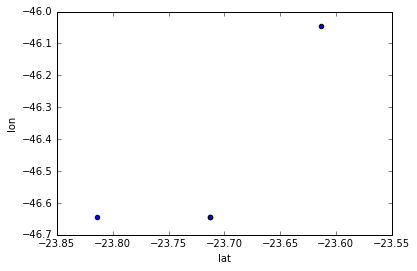

In [343]:
clusters = cluster(get_OD(remove_inter(df)), 2)
plot_cluster(clusters[0])

In [344]:
def cluster_on_map(cluster):
    m = folium.Map(location=[cluster.lat.mean(), cluster.lon.mean()])
    colors = ["green","blue", "red", "orange", "brown", "yellow", "white"]
    i = 0
    for index, row in cluster.iterrows():
        
        folium.features.PolyLine([row.loc["lat_orig":"long_orig"].values.tolist(),
                                   row.loc["lat":"lon"].values.tolist()], color=colors[i], weight=row["count"]).add_to(m)
        i+=1
    return m

In [346]:
print(clusters[0])

         id_orig           time_orig  lat_orig  long_orig     lat      lon  \
cluster                                                                      
0              1 1900-01-01 03:50:00   -23.713   -46.6443 -23.814 -46.6443   
1              1 1900-01-01 03:12:00   -23.613   -46.0443 -23.713 -46.6443   

         cluster  count  
cluster                  
0              0      3  
1              1      1  


In [345]:
cluster_on_map(clusters[0])

=top - 01:47:37 up 14:05,  5 users,  load average: 3,00, 2,62, 2,58
Tasks: 231 total,   1 running, 230 sleeping,   0 stopped,   0 zombie
%Cpu(s): 55,9 us,  0,5 sy,  0,0 ni, 42,8 id,  0,7 wa,  0,0 hi,  0,0 si,  0,0 st
KiB Mem:   8072044 total,  5605884 used,  2466160 free,   304320 buffers
KiB Swap: 24082424 total,        0 used, 24082424 free.  2208844 cached Mem

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
 2918 luke      20   0  878252 135016  54408 S  94,4  1,7   1:24.15 chrome      
 2703 luke      20   0  559560 178928 106376 S  18,9  2,2  12:17.10 chrome      
 5198 luke      20   0 1497328 721728 574536 S  18,9  8,9  19:37.97 chrome      
 2609 luke      20   0 2080380 435848 150108 S  12,6  5,4  21:16.82 chrome      
 1105 root      20   0  289772  43204  32640 S   6,3  0,5   7:11.18 Xorg        
 3032 luke      20   0 2366388 211152  54416 S   6,3  2,6   1795:49 chrome      
    1 root      20   0   33920   4436   2692 S   0,0  0,1   0:01.

In [347]:
def cluster(df, n_clusters, freq=False):
    df = df.dropna(axis=0, how='any')
    clustered = []

    if freq:
        groups = []
        for name, group in df.groupby([df.time_orig.dt.hour]):

            if group.shape[0] == 1:
                continue
       
            group["cluster"] = get_clusters(group.loc[:,"lat_orig":"lon"].values, n_clusters, bundling_metric)
            groups += [group]
            grouped = group.groupby(group.cluster)
            representative = []
            for name, g in grouped:
                representative += [[g.lat_orig.mean(), g.long_orig.mean(), g.lat.mean(), g.lon.mean(), g.shape[0]]]
        #representative = grouped.first()
        #representative["count"] = grouped.size()
            clustered += [representative]
        return clustered, groups
    else:
        df["cluster"] = get_clusters(df.loc[:, "lat_orig":"lon"].values, n_clusters, bundling_metric)

        grouped = df.groupby(df.cluster)
        representative = []
        for name, g in grouped:
            representative += [[g.lat_orig.mean(), g.long_orig.mean(), g.lat.mean(), g.lon.mean(), g.shape[0], name]]
        clustered += [representative]
    #return pd.concat(clustered)
        return clustered, df

In [348]:
def cluster_on_map(clustered, original, df=True):


    print(clustered)
    colors = sum([["green", "blue", "red", "orange", "brown", "yellow",
                   "white"] for i in range(1000)], [])
    if df:
        m = folium.Map(location=[clustered.lat.mean(), clustered.lon.mean()])
    else:
        m = folium.Map(location=[sum([cl[0] for cl in clustered]) / len(clustered), sum([cl[1] for cl in clustered])/len(clustered)])



    i = 0
    if df:
        for index, row in clustered.iterrows():

            folium.features.PolyLine([row.loc["lat_orig":"long_orig"].values.tolist(),
                                       row.loc["lat":"lon"].values.tolist()], color=colors[i], weight=row["count"]).add_to(m)
            i += 1
        return m

    for r in clustered:
        folium.features.PolyLine([r[:2],
                                  r[2:4]], color=colors[i], weight=r[4]).add_to(m)

        #for name, group in original.groupby(original.cluster):
         #   if name == r[5]:
         #       for index, row in group.iterrows():
          #          folium.Marker([row.lat, row.lon], icon=folium.Icon(color=colors[i])).add_to(m)
           #         folium.Marker([row.lat_orig, row.long_orig], icon=folium.Icon(color=colors[i])).add_to(m)

        #folium.features.PolyLine([row.loc["lat_orig":"long_orig"].values.tolist(),
        #                           row.loc["lat":"lon"].values.tolist()], color=colors[i], weight=row["count"]).add_to(m)
        i+=1
    return m

In [351]:
clusters, orig = cluster(get_OD(remove_inter(df)), 2)
cluster_on_map(clusters[0], orig, df=False)

/home/luke/freya_home/luke/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/luke/freya_home/luke/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[[-23.51325, -46.869299999999996, -23.6385, -46.869299999999996, 4, 0], [-23.7135, -46.344300000000004, -23.713, -46.344300000000004, 2, 1]]


In [365]:
clusters, orig = cluster(get_OD(remove_inter(john)), 2)
cluster_on_map(clusters[0], orig, df=False)

/home/luke/freya_home/luke/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/luke/freya_home/luke/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[[-23.464047222222227, -46.55957916666666, -23.464047222222227, -46.522189166666664, 2, 0], [-23.399715423583984, -46.52352523803711, -23.464047222222227, -46.58324166666666, 1, 1]]


In [368]:
orig["count"] = [1 for i in range(orig.shape[0])]
cluster_on_map(orig, orig)

         id_orig           time_orig   lat_orig  long_orig        lat  \
cluster                                                                 
0         440224 1900-01-01 03:12:00 -23.399715 -46.523525 -23.464047   
1         440224 1900-01-01 03:50:00 -23.464047 -46.583242 -23.464047   
2         440224 1900-01-01 04:12:00 -23.464047 -46.535917 -23.464047   

               lon  cluster  count  
cluster                             
0       -46.583242        1      1  
1       -46.535917        0      1  
2       -46.508462        0      1  


In [396]:
clusters, orig = cluster(get_OD(remove_inter(merged_new)), 5)
cluster_on_map(clusters[0], orig, df=False)

/home/luke/freya_home/luke/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/luke/freya_home/luke/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[[-23.48372382635989, -46.892017120956524, -23.512553477783577, -46.91060201465316, 5, 0], [-23.47772630876614, -46.84412505716288, -23.458496596845304, -46.89459712132458, 3, 1], [-23.530289506435103, -46.87102684178004, -23.52131295042159, -46.86848141344673, 7, 2], [-23.5342294239655, -46.829203729330025, -23.454256016743315, -46.83631198597503, 1, 3], [-23.525237589328903, -46.902059442492224, -23.456797704610523, -46.8422718513826, 1, 4]]


In [397]:
orig["count"] = [1 for i in range(orig.shape[0])]
cluster_on_map(orig, orig)

         id_orig           time_orig   lat_orig  long_orig        lat  \
cluster                                                                 
0           8695 2017-10-07 07:59:58 -23.525238 -46.902059 -23.456798   
0          84232 2017-10-07 08:32:58 -23.528576 -46.921810 -23.481305   
0          89837 2017-10-07 08:59:57 -23.530169 -46.850778 -23.522736   
0         187245 2017-10-07 08:32:58 -23.551441 -46.832732 -23.517169   
0         385271 2017-10-07 07:59:58 -23.455070 -46.895494 -23.537963   
0         425787 2017-10-07 07:43:14 -23.541572 -46.901274 -23.533555   
0         429234 2017-10-07 08:54:27 -23.534229 -46.829204 -23.454256   
0         629704 2017-10-07 08:59:57 -23.467659 -46.859799 -23.495552   
0         640782 2017-10-07 08:32:58 -23.474867 -46.849646 -23.459486   
0         672921 2017-10-07 07:59:13 -23.486953 -46.846791 -23.464121   
0         719123 2017-10-07 08:32:58 -23.537348 -46.855883 -23.501936   
0         750756 2017-10-07 08:32:58 -23.517139 -46